# Model 8 - Random Forest Regressor (error: 1191.035271)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")


In [22]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [23]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [24]:
test.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,4705.000000,5681.000000,5681.000000,5681.000000
mean,12.695633,0.065684,141.023273,1997.828903
std,4.664849,0.051252,61.809091,8.372256
min,4.555000,0.000000,31.990000,1985.000000
25%,8.645000,0.027047,94.412000,1987.000000
50%,12.500000,0.054154,141.415400,1999.000000
75%,16.700000,0.093463,186.026600,2004.000000
max,21.350000,0.323637,266.588400,2009.000000


In [25]:
#Check for missing values - If unique>1 then missing values
(train.isnull()).describe()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523,8523,8523,8523,8523,8523,8523,8523,8523,8523,8523,8523
unique,1,2,1,1,1,1,1,1,2,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False
freq,8523,7060,8523,8523,8523,8523,8523,8523,6113,8523,8523,8523


In [26]:
#Missing Value Treatment

#Item Visibility is 0 
train.Item_Visibility.replace(0,train.Item_Visibility.mean(),inplace=True)
test.Item_Visibility.replace(0,test.Item_Visibility.mean(),inplace=True)

#Item Weight is null
train.Item_Weight.fillna(train.Item_Weight.mean(),inplace=True)
test.Item_Weight.fillna(test.Item_Weight.mean(),inplace=True)

#Outlet Size is null
train.Outlet_Size.fillna(train.Outlet_Size.mode(),inplace=True)
test.Outlet_Size.fillna(test.Outlet_Size.mode(),inplace=True)

#get test_outlets_ids
test_outlet_ids = test.Outlet_Identifier

#Feature - How old is the outlet
train["Outlet_Age"] = 2013 - train.Outlet_Establishment_Year 
test["Outlet_Age"] = 2013 - test.Outlet_Establishment_Year 

In [27]:
#Converting categorical to One Hot Encoding
cat_list = list((train.select_dtypes(include=["object"])).columns)
cat_list.remove("Item_Identifier")
for cat in cat_list:
    print train[cat].describe()


count        8523
unique          5
top       Low Fat
freq         5089
Name: Item_Fat_Content, dtype: object
count                      8523
unique                       16
top       Fruits and Vegetables
freq                       1232
Name: Item_Type, dtype: object
count       8523
unique        10
top       OUT027
freq         935
Name: Outlet_Identifier, dtype: object
count       6113
unique         3
top       Medium
freq        2793
Name: Outlet_Size, dtype: object
count       8523
unique         3
top       Tier 3
freq        3350
Name: Outlet_Location_Type, dtype: object
count                  8523
unique                    4
top       Supermarket Type1
freq                   5577
Name: Outlet_Type, dtype: object


In [28]:
dummies = pd.get_dummies(train[cat_list],prefix=cat_list)
train.drop(cat_list,axis=1,inplace=True)
train = pd.concat([train,dummies],axis=1)

dummies = pd.get_dummies(test[cat_list],prefix=cat_list)
test.drop(cat_list,axis=1,inplace=True)
test = pd.concat([test,dummies],axis=1)

### Cross Validation

In [29]:
from sklearn.model_selection import train_test_split

y = train["Item_Outlet_Sales"]
train_ids = train.Item_Identifier
x = train.drop(["Item_Outlet_Sales","Item_Identifier","Outlet_Establishment_Year"],axis=1)

x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size=0.3) 

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# for mmin in [2,4,6,8,10,20,30,40,50,60,70]:
rfr_cv = RandomForestRegressor(random_state=0,n_estimators=500,max_features="sqrt",max_depth=20,oob_score=True,min_samples_leaf=2)
rfr_cv = rfr_cv.fit(x_train,y_train)
pred_cv = rfr_cv.predict(x_cv)
mse = np.mean((pred_cv-y_cv)**2)
crossval = cross_val_score(rfr_cv,x_train,y_train,cv=10,scoring="mean_squared_error")

print np.sqrt(mse),crossval

/usr/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/site-packages/sklearn/metri

1144.12036564 [-1419814.31971328 -1039330.04023741 -1180955.38232112 -1411799.69925297
 -1245481.14935955 -1347945.23047066 -1206734.19122956 -1127732.94712438
 -1143724.86743595 -1179271.28266516]


In [31]:
np.sqrt(crossval*-1)

array([ 1191.55961652,  1019.475375  ,  1086.7177105 ,  1188.19177714,
        1116.01126758,  1161.01043513,  1098.51453847,  1061.94771393,
        1069.45073165,  1085.94257798])

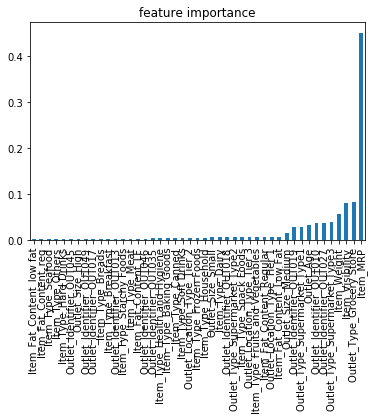

In [32]:
feat = pd.Series(rfr_cv.feature_importances_, x_train.columns).sort_values()
feat.plot(kind="bar",title="feature importance")
plt.show()

### Submission

In [48]:
y = train["Item_Outlet_Sales"]
train_ids = train.Item_Identifier
x = train.drop(["Item_Identifier","Item_Outlet_Sales","Outlet_Establishment_Year"],axis=1)
test_ids = test.Item_Identifier
test = test.drop(["Item_Identifier","Outlet_Establishment_Year"],axis=1)


In [55]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=0,n_estimators=500,max_features="sqrt",max_depth=20,oob_score=True,min_samples_leaf=2)
rfr = rfr.fit(x,y)
pred = rfr.predict(test)


In [57]:
outdf = pd.DataFrame({"Item_Identifier":test_ids,"Outlet_Identifier":test_outlet_ids,"Item_Outlet_Sales":pred})
outdf.to_csv("sub.csv")

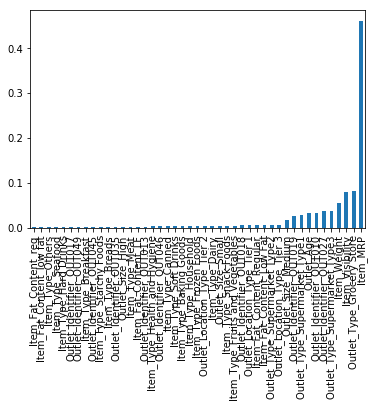

In [77]:
feat = pd.Series(rfr.feature_importances_, x.columns).sort_values()
feat.plot(kind="bar")
plt.show()

In [59]:
x.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Age,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0.016047,249.809,14,0,1,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
1,5.92,0.019278,48.2692,4,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,17.50,0.016760,141.618,14,0,1,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
3,19.20,0.066132,182.095,15,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,8.93,0.066132,53.8614,26,0,1,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0


In [70]:
plt.bar(x.Item_Weight,y)

<Container object of 8523 artists>

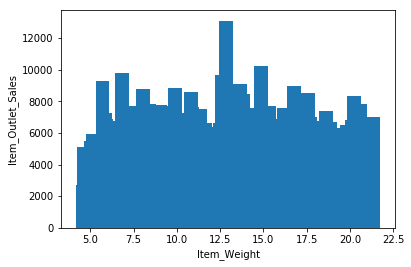

In [71]:
plt.xlabel("Item_Weight")
plt.ylabel("Item_Outlet_Sales")
plt.show()